In [8]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

**Warning: this is a work-in-progress draft**

# Discover community structure using `igraph` and `leidenalg`

See also: <https://arxiv.org/abs/1810.08473>

Since there are difficulties getting `igraph` to install correctly across different environments, `kglab` does not have it as a dependency. Instead you'll need to install the following packages separately:

In [9]:
!pip install cairocffi
!pip install igraph
!pip install leidenalg

After successful installs, next we'll import the packages:

In [10]:
import igraph as ig
import leidenalg as la

Create a graph based on the Zachary karate club, a famous example used in network science: 

In [11]:
G = ig.Graph.Famous("Zachary")

Find a partition, i.e., detect communities with modularity, then plot using `python-igraph` and `cairocffi`:

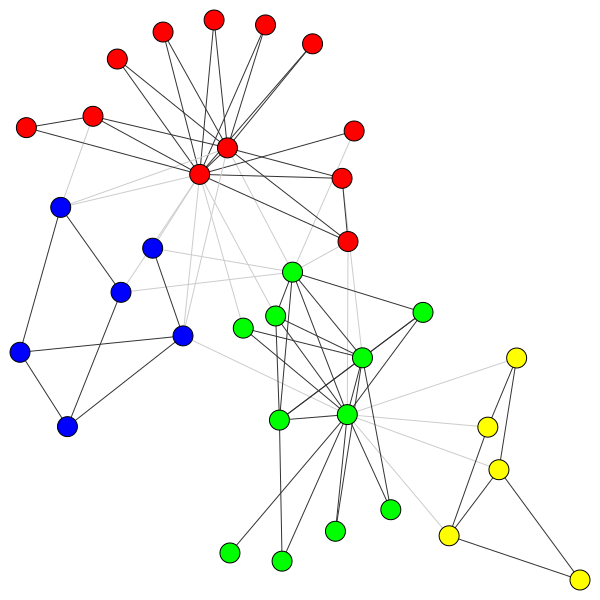

In [12]:
partition = la.find_partition(G, la.ModularityVertexPartition)
ig.plot(partition)

---

## Integration with `kglab`

In [13]:
from os.path import dirname
import kglab
import os

namespaces = {
    "nom":  "http://example.org/#",
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    }

kg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    namespaces = namespaces,
    )

kg.load_rdf(dirname(os.getcwd()) + "/dat/recipes.ttl") ;

In [14]:
sparql = """
    SELECT ?subject ?object
    WHERE {
        ?subject rdf:type wtm:Recipe .
        ?subject wtm:hasIngredient ?object .
    }
    """

In [15]:
import igraph as ig

subgraph = kglab.SubgraphMatrix(kg, sparql)
ig_graph = subgraph.build_ig_graph(ig.Graph())

In [16]:
ig_graph.vs[0].attributes()

{'name': 'http://example.org/#Batter', 'label': 'http://example.org/#Batter'}

Serialize to [`GraphML`](http://graphml.graphdrawing.org/) format:

In [17]:
with open("tmp.graphml", "w") as f:
    ig_graph.write_graphml(f)

## Community detection

In [18]:
component = ig_graph.components().subgraph(0)
partition = la.find_partition(component, la.ModularityVertexPartition)

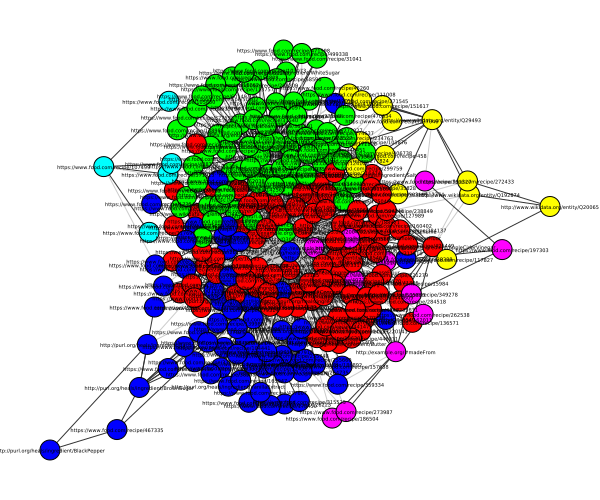

In [19]:
ig.plot(partition, bbox=(600, 500), vertex_label_size=5, margin=50)

Let's look into the community that involves `ind:Butter`, `nom:Pancake`, etc.

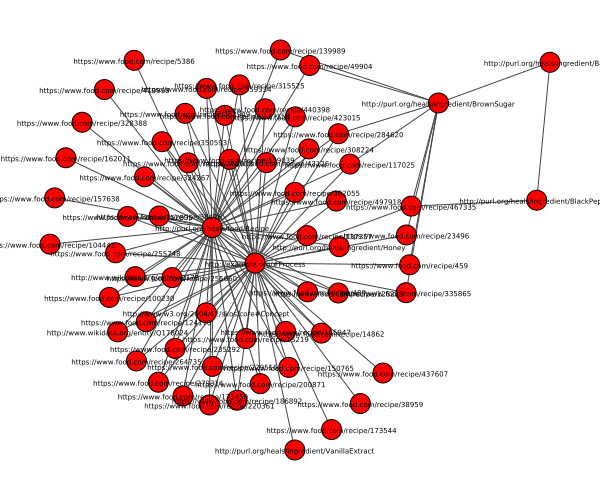

In [20]:
ig.plot(partition.subgraph(2), bbox=(600, 500), vertex_label_size=7, margin=50)